This notebook aims to explain the CORONET score produced by the Random Forest regression model.

Each input feature is investigated using SHAP values in order to understand the relation between the feature and its impact on the calculation of the score.

The CORONET tool is available at:
www.coronet.manchester.ac.uk

The paper describing the model development and the clinical details of training cohort can be found here:
https://www.medrxiv.org/content/10.1101/2020.11.30.20239095v1



__________

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import shap
import sys

In [2]:
#module_path = r'C:\Users\d07321ow\Google Drive\Cytokine\COVID19\Cancer_calculator\CORONET_python'
module_path = r'...'
if module_path not in sys.path:
    sys.path.append(module_path)
#import CORONET_functions as f
import CORONET_code_for_tool as f

import importlib
importlib.reload(f)

<module 'CORONET_functions' from 'C:\\Users\\d07321ow\\Google Drive\\Cytokine\\COVID19\\Cancer_calculator\\CORONET_python\\CORONET_functions.py'>

# Load model and explainer

In [3]:
model_path = '...\CORONET_RF_model.pkl'

explained_path = r'...\CORONET_RF_explainer.plk'

In [4]:
model = f.load_predictive_model(model_path)

In [5]:
explainer = f.load_predictive_model(explained_path)

In [88]:
df = pd.read_csv(r'...\data.csv')
coronet_score = pd.read_csv(r'...\CORONET_279_predictions.csv', index_col=0)

X=df.iloc[:,1:-1]

# Get explanation for all patients in the training cohort

SHAP values are obtained by using *shap python library* (SHAP (SHapley Additive exPlanations https://github.com/slundberg/shap)

In [108]:
shap_values = explainer(X)

# Note

Model explanations presented in the following sections intend to develop an intuition about how the model works and what are the relations between individual features on the final predicted score. Remember that the CORONET model is a multivariable Random Forest regression model, which incorporates interrelations between features that are not possible to show on the plots below. However, we did our best (and still persuing for better explanation - any feedback approciated!). 

## Define plotting function

In [284]:
def plot_shap_values_and_true_outcome(shap_values, true_outcome, column, point_alpha=0.5, point_size=100, ylim=[-.3, .3], ax=False):
    if ax==False:
        fig, ax = plt.subplots(figsize=(12,10))
    
        

    x = shap_values[:, column].data
    y = shap_values[:, column].values

    alpha=0.5
    size = 100
    ax.scatter(x[true_outcome==0],y[true_outcome==0], s=point_size,color='green',marker='o', alpha=point_alpha, label = 'Discharged')
    ax.scatter(x[true_outcome==1],y[true_outcome==1], s=point_size, color='orange', marker = 'X', alpha=point_alpha, label = 'Admitted')
    ax.scatter(x[true_outcome==2],y[true_outcome==2], s=point_size, color='blue', marker ='s', alpha=point_alpha, label = 'Required oxygen')
    ax.scatter(x[true_outcome==3],y[true_outcome==3], s=point_size, color='black', marker='P', alpha=point_alpha, label = 'Died')

    title = column + ' contribution to CORONET score'
    ax.set_title(title)
    ax.set_ylim(ylim)
    ax.axhline(0, 0,1,color='gray', linestyle='--')
    ax.set_xlabel(column)
    ax.set_ylabel('SHAP value')
    ax.legend(title='True outcome')
    #ax.annotate('towards ADMISSION', xy=())
    
   
    return ax

# Numeric features

## Age

In [322]:
y0_intersection = shap_values[:,'Age'].data[shap_values[:,'Age'].values<0].max()
y0_intersection

75.0

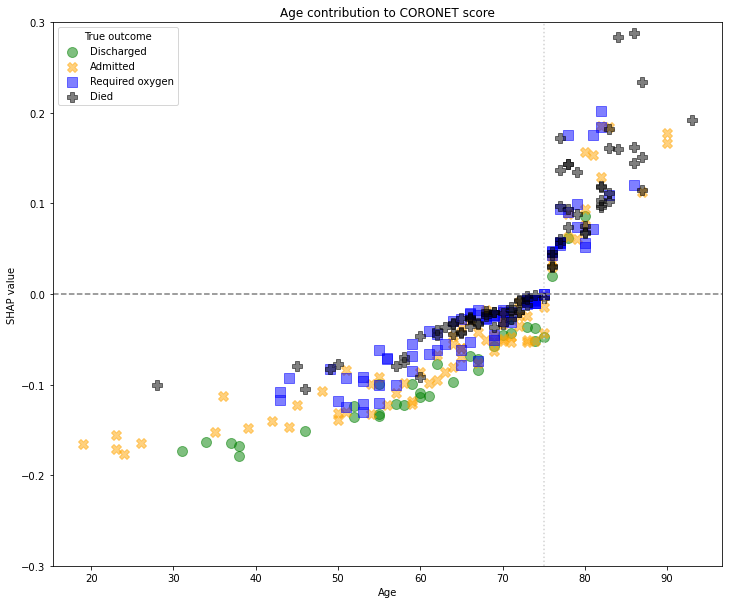

In [323]:
ax=plot_shap_values_and_true_outcome(shap_values, df['y'].values, 'Age')
ax.axvline(y0_intersection, linestyle=':', color='lightgray');

**Interpretation:**

it is expected that for majority of cases, the age over 75 will be identified by the CORONET model as a factor for admission.

## NEWS2

In [325]:
y0_intersection = np.round(shap_values[:,'NEWS2'].data[shap_values[:,'NEWS2'].values<0].max())
y0_intersection

4.0

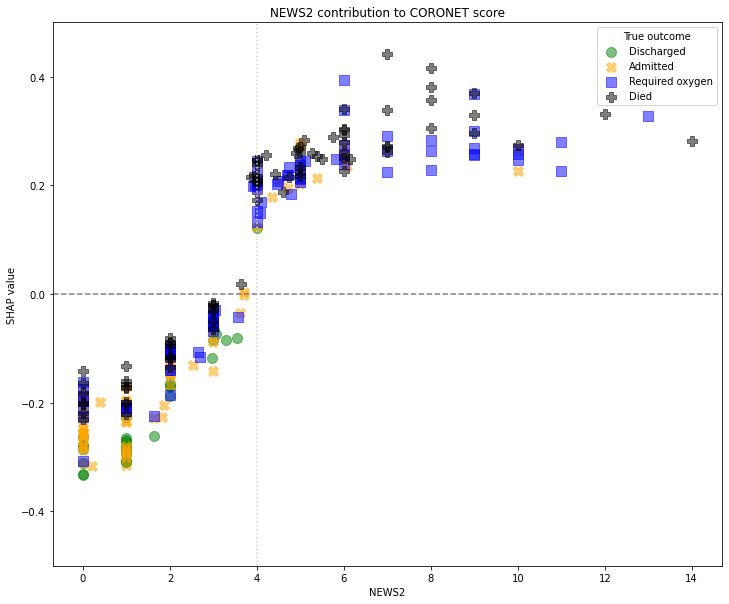

In [327]:
ax=plot_shap_values_and_true_outcome(shap_values, df['y'].values, 'NEWS2', ylim=[-.5,0.5])
ax.axvline(y0_intersection, linestyle=':', color='lightgray');

**Interpretation:**

it is expected that for majority of cases, the NEWS2 equal or higher than 4 will be identified by the CORONET model as a factor for admission.

## Platelets

In [261]:
y0_intersection = shap_values[:,'Platelets'].data[shap_values[:,'Platelets'].values>0].max()
y0_intersection

171.0

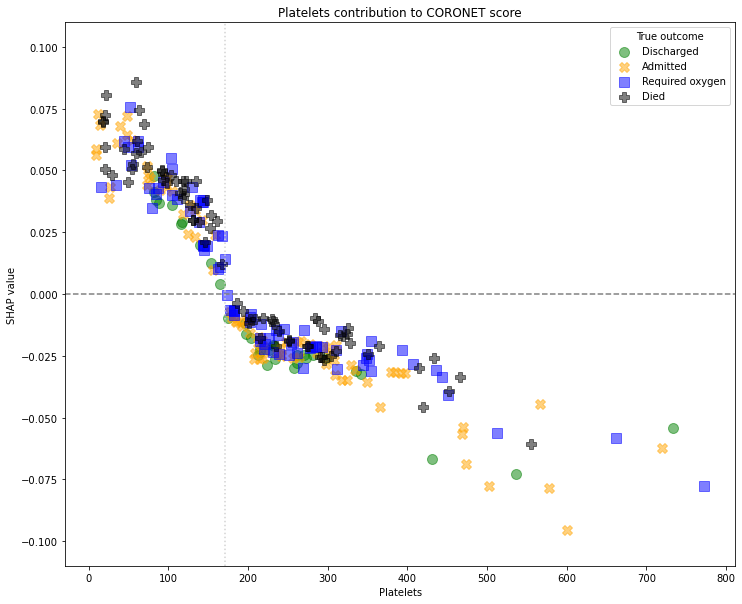

In [270]:
ax=plot_shap_values_and_true_outcome(shap_values, df['y'].values, 'Platelets', ylim=[-.11,0.11])
ax.axvline(y0_intersection, linestyle=':', color='lightgray');

**Interpretation:**

it is expected that for majority of cases, the Platelets lower than 171 will be identified by the CORONET model as a factor for admission.

## Albumin

In [271]:
y0_intersection = shap_values[:,'Albumin'].data[shap_values[:,'Albumin'].values>0].max()
y0_intersection

35.210182361416976

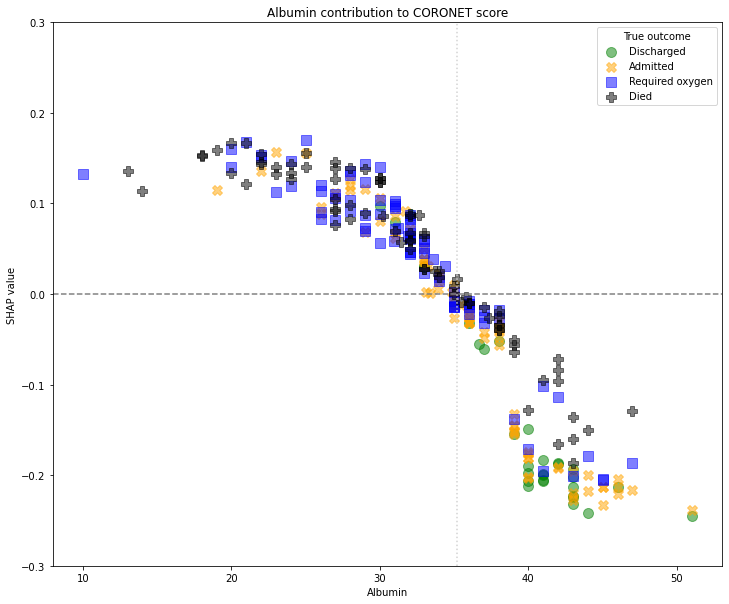

In [273]:
ax=plot_shap_values_and_true_outcome(shap_values, df['y'].values, 'Albumin', ylim=[-.3,0.3])
ax.axvline(y0_intersection, linestyle=':', color='lightgray');

**Interpretation:**

it is expected that for majority of cases, the Albumin lower than ~35 will be identified by the CORONET model as a factor for admission.

## CRP

In [280]:
y0_intersection = 2**shap_values[:,'log2_CRP'].data[shap_values[:,'log2_CRP'].values>0].min()
y0_intersection

39.100000000000016

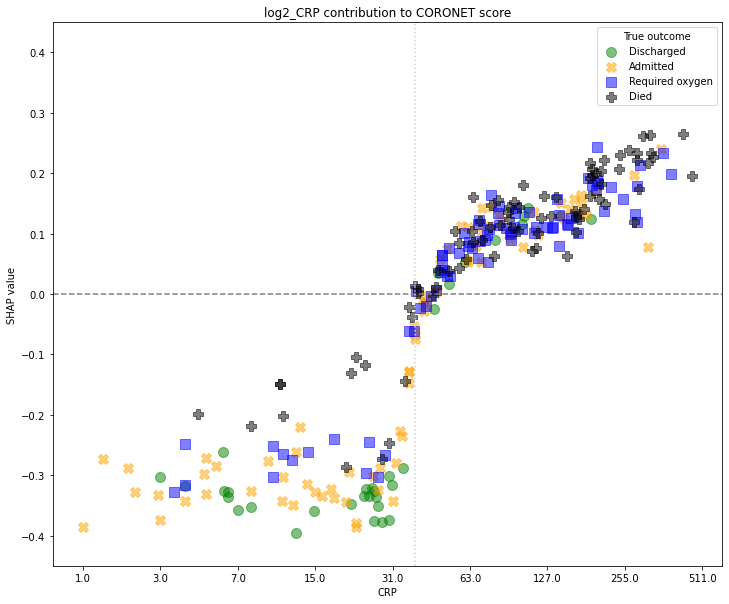

In [281]:
ax=plot_shap_values_and_true_outcome(shap_values, df['y'].values, 'log2_CRP', ylim=[-.45,0.45])
ax.axvline(np.log2(y0_intersection), linestyle=':', color='lightgray')
ax.set_xticklabels(np.round((2**ax.get_xticks()-1)));
ax.set_xlabel('CRP');

In [255]:
2**(shap_values[:,'log2_CRP'].data[shap_values[:,'log2_CRP'].values>0].min())

39.100000000000016

**Interpretation:**

it is expected that for majority of cases, the CRP higher than ~39 will be identified by the CORONET model as a factor for admission.

## Neutrophil:Lymphocyte Ratio (NLR)

In [282]:
y0_intersection = 2**shap_values[:,'log2_NLR'].data[shap_values[:,'log2_NLR'].values>0].min()
y0_intersection

13.057142860000003

Text(0.5, 0, 'NLR')

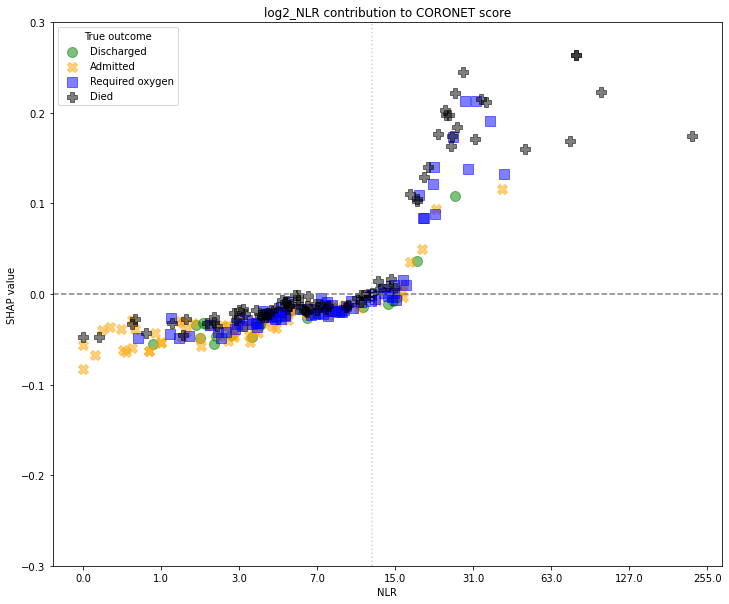

In [283]:
ax=plot_shap_values_and_true_outcome(shap_values, df['y'].values, 'log2_NLR', ylim=[-.3,0.3])
ax.axvline(np.log2(y0_intersection), linestyle=':', color='lightgray')
ax.set_xticklabels(np.round((2**ax.get_xticks()-1)));
ax.set_xlabel('NLR');

**Interpretation:**

it is expected that for majority of cases, the Neutrophil:Lymphocyte Ratio higher than ~13 will be identified by the CORONET model as a factor for admission. 

High values of NLR (>16) pressumably have much higher impact on increasing the CORONET score, than low values (<16) have the impact on decreasing the score.

## Overall features comparison

In [288]:
df.columns

Index(['Record_ID', 'Age', 'Total_nb_comorbidities', 'haematological_cancer',
       'Cancer_stage_12', 'Cancer_stage_3', 'Cancer_stage_4', 'NEWS2',
       'Platelets', 'Albumin', 'log2_CRP', 'log2_NLR', 'y'],
      dtype='object')

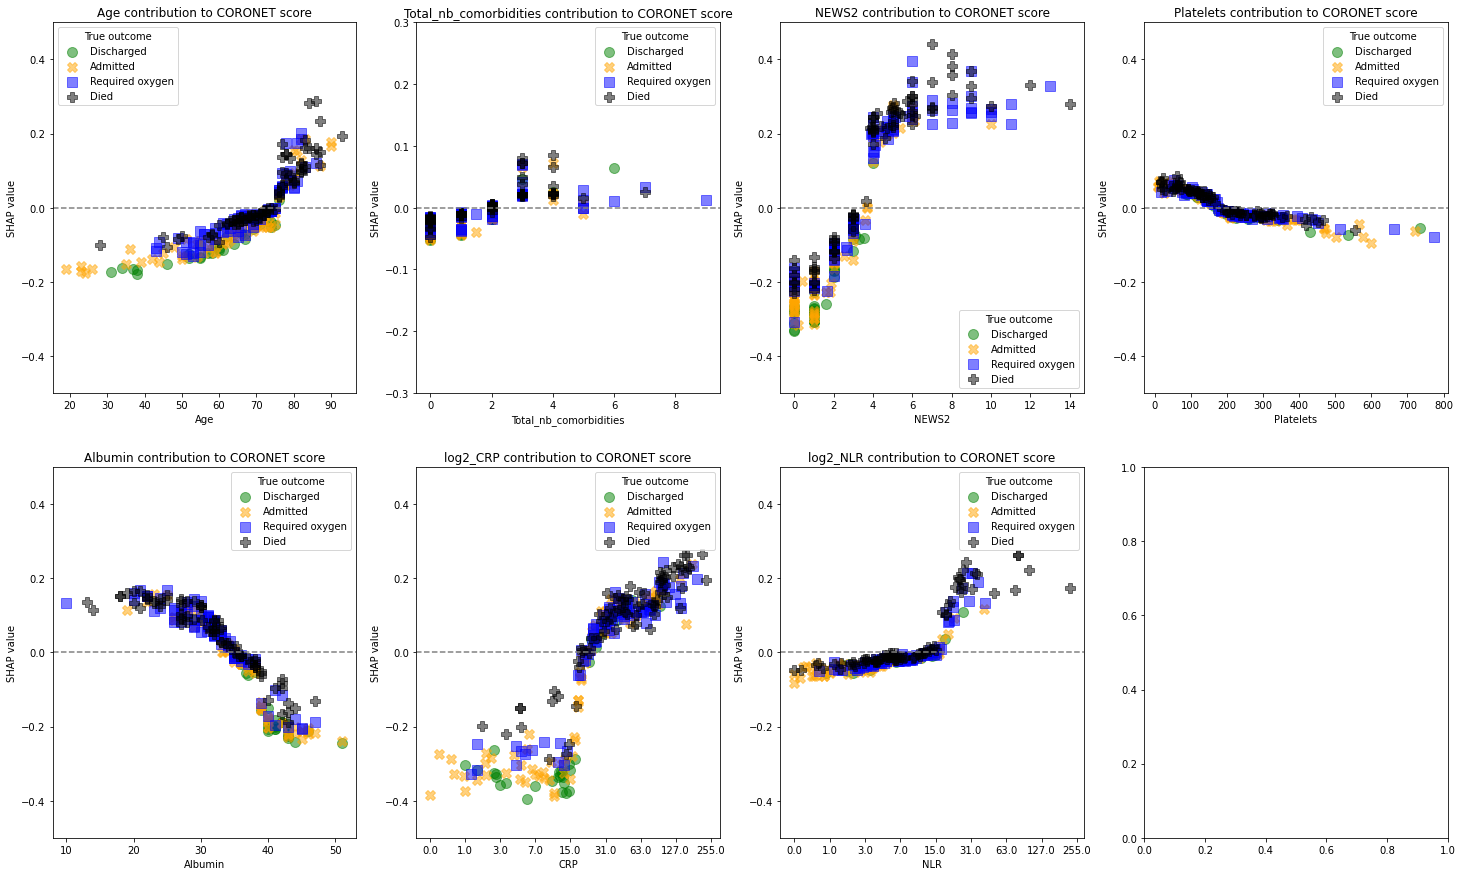

In [312]:
fig, axs = plt.subplots(2,4, figsize = (25,15))
ylim = [-.5,.5]
axs=axs.reshape(-1,)
plot_shap_values_and_true_outcome(shap_values, df['y'].values, 'Age', ylim=ylim ,ax=axs[0])

plot_shap_values_and_true_outcome(shap_values, df['y'].values, 'Total_nb_comorbidities', ylim=[-.3,0.3] ,ax=axs[1])

plot_shap_values_and_true_outcome(shap_values, df['y'].values, 'NEWS2', ylim=ylim ,ax=axs[2])

plot_shap_values_and_true_outcome(shap_values, df['y'].values, 'Platelets', ylim=ylim,ax=axs[3])

plot_shap_values_and_true_outcome(shap_values, df['y'].values, 'Albumin', ylim=ylim ,ax=axs[4])

plot_shap_values_and_true_outcome(shap_values, df['y'].values, 'log2_CRP', ylim=ylim ,ax=axs[5])
axs[5].set_xticklabels(np.round((2**ax.get_xticks()-1)));
axs[5].set_xlabel('CRP');

plot_shap_values_and_true_outcome(shap_values, df['y'].values, 'log2_NLR', ylim=ylim ,ax=axs[6])
axs[6].set_xticklabels(np.round((2**ax.get_xticks()-1)));
axs[6].set_xlabel('NLR');

**Interpretation:**

Y axis is intentionally set equal in the plots above. Note that some of the features (in majority of cases) have much higher impact on the prediction - higher absolute SHAP values. This is also reflected in the feature importance plots in the next section.

# Random Forest feature importance

### Gini importance plot

The impurity-based feature importances.

The higher, the more important the feature.

More info: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=random%20forest%20regressor#sklearn.ensemble.RandomForestRegressor.feature_importances_

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


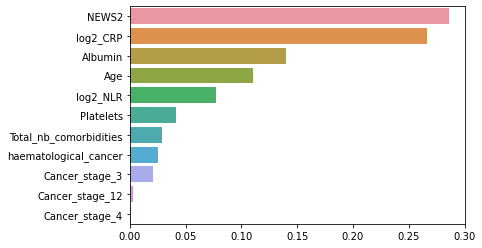

In [313]:
sns.barplot(model.feature_importances_, X.columns,  orient='h', order = X.columns[np.argsort(model.feature_importances_)[::-1]])

### SHAP beeswarm plot

The higher, the more important the feature.

More info: https://shap.readthedocs.io/en/latest/generated/shap.summary_plot.html

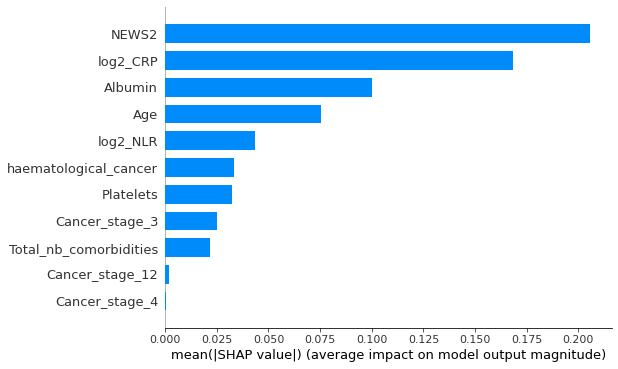

In [316]:
shap.summary_plot(shap_values.values, X, plot_type="bar", max_display=15)

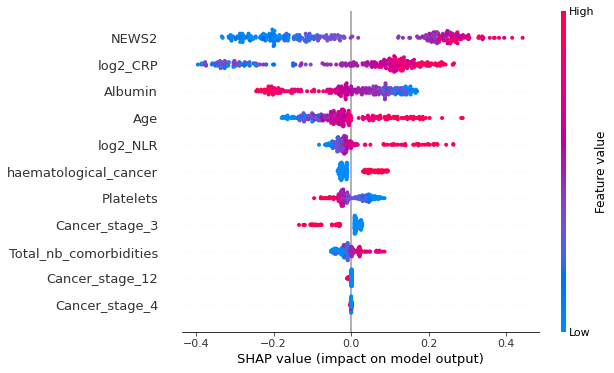

In [11]:
shap.summary_plot(shap_values.values, X, plot_type="dot", max_display=15)

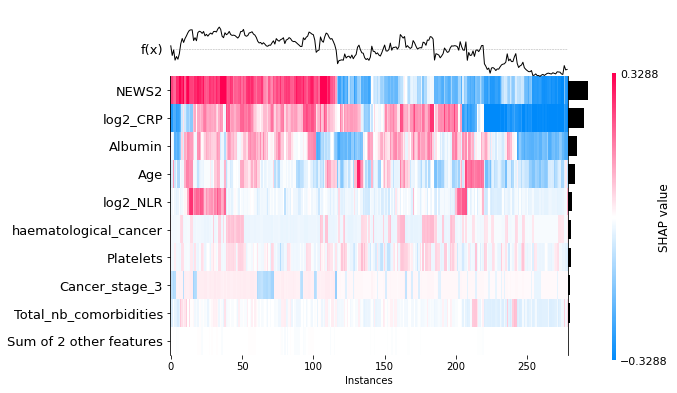

In [317]:
shap.plots.heatmap(shap_values)

# Categorical features

tbc...